In [2]:
import esm
import sys, os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cmap = plt.get_cmap("tab20c")
sns.set(font_scale=1)
pd.set_option('display.max_columns', 50)
sns.set_style("white")

file_path = "/home/ch3849/SAE_mut/code/model_relu"
sys.path.append(file_path)
from dictionary import AutoEncoder

### load the max_value and active_percentage in human proteome

L0: 10179.19, 
all activated features: 20480


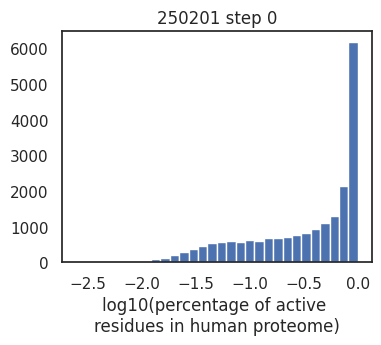

In [8]:
sae_model = 250201
chk = 0

active_p_path = f'/share/vault/Users/ch3849/esm_sae/model/{sae_model}/normalize/active_percentage_training10k_chk{chk}.npy'
# active_p_path = f'/share/vault/Users/ch3849/esm_sae/model/{sae_model}/normalize/active_percentage_human_chk{chk}.npy'
active_p = np.load(active_p_path)

print(f'L0: {round(active_p.sum(), 2)}, \nall activated features: {(active_p != 0).sum()}')

plt.figure(figsize=[4,3])
plt.hist(np.log10(active_p[active_p > 0]), bins=30)
plt.title(f'{sae_model} step {chk}')
plt.xlabel('log10(percentage of active \nresidues in human proteome)')
plt.show()

### normalize the model weight

In [11]:
max_value_path = f'/share/vault/Users/ch3849/esm_sae/model/{sae_model}/normalize/max_value_human_chk{chk}.npy'
max_value = np.load(max_value_path)

# set all the max_value of zero to one (as these values will be devided)
max_value_0to1 = torch.tensor(max_value)
max_value_0to1[max_value_0to1 == 0] = 1

chk_path = f'/share/vault/Users/ch3849/esm_sae/model/{sae_model}/checkpoints/step_{chk}.pt'
weight = torch.load(chk_path, map_location='cpu')

/tmp/ipykernel_196013/3196624389.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(chk_path, map_location='cpu')


In [12]:
weight['encoder.weight'] = weight['encoder.weight'].div_(max_value_0to1.unsqueeze(1))
weight['encoder.bias'] = weight['encoder.bias'].div_(max_value_0to1)
weight['decoder.weight'] = weight['decoder.weight'].mul_(max_value_0to1.unsqueeze(0))

In [13]:
normalize_chk_path = f'/share/vault/Users/ch3849/esm_sae/model/{sae_model}/checkpoints/step_{chk}_normalized.pt'
torch.save(weight, normalize_chk_path)